In [3]:
%reload_ext autoreload
%autoreload 2

In [40]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate

from elections import constants
from elections.scrapers.news_scraper import NewsScraper
from elections.data_schemas import ArticleSentiment
from elections.sentiment_analysis import SentimentAnalysis

In [41]:
articles_df = NewsScraper.load_articles()
articles_df["pubdate"] = pd.to_datetime(articles_df["pubdate"])

sentiments_df = SentimentAnalysis.load_article_sentiments()

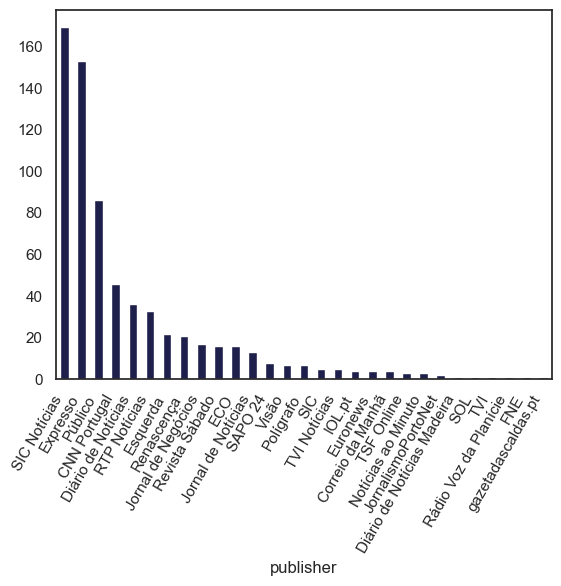

In [485]:
articles_df["publisher"].value_counts().plot.bar()
plt.xticks(rotation=60, ha='right');

In [5]:
def expand_analysis(row):
    analysis = []
    sentiments = row["analysis"].sentiments
    if not sentiments:
        return pd.DataFrame([{"quote": None, "score": None, "name": None, "article_id": row["article_id"]}])
    for sent in sentiments:
        if sent.citations:
            df = pd.DataFrame(
                [{"quote": cite.quote, "quote_score": cite.score} for cite in sent.citations]
            )
        else:
            df = pd.DataFrame([{"quote": None, "score": None}])
        df["name"] = sent.name
        df["score"] = sent.score
        df["article_id"] = row["article_id"]     
        analysis.append(df)
    
    analysis = [df.dropna(axis=1, how='all') for df in analysis]
    return pd.concat(analysis, ignore_index=True)
        

In [7]:
article_with_sentiments = ~sentiments_df["analysis"].isnull()
expanded = sentiments_df.loc[article_with_sentiments, ["article_id", "analysis"]].apply(expand_analysis, axis=1)
expanded_sentiments = pd.concat([df.dropna(axis=1, how='all') for df in expanded], ignore_index=True)
expanded_sentiments

,quote,quote_score,name,score,article_id
0,Luís Montenegro manteve aquilo que faz dele um...,0.8,Luís Montenegro,0.5,1
1,Pedro Nuno Santos disse: ‘Eu não negoceio sobr...,0.3,Luís Montenegro,0.5,1
2,Pedro Nuno Santos esteve a descansar este temp...,0.7,Pedro Nuno Santos,0.6,1
3,Pedro Nuno Santos entrou ao ataque. A frase da...,0.7,Pedro Nuno Santos,0.6,1
4,"Pedro Nuno Santos não teve debates brilhantes,...",0.4,Pedro Nuno Santos,0.6,1
...,...,...,...,...,...
1672,"António José Teixeira, diretor de informação d...",0.4,Luís Montenegro,0.5,685
1673,"Perante a sugestão da AD, que 'entendeu propor...",0.3,Luís Montenegro,0.5,685
1674,'O que esteve sempre na base deste modelo foi ...,0.5,Luís Montenegro,0.5,685
1675,NaN,NaN,Paulo Raimundo,NaN,685


In [8]:
expanded_sentiments[expanded_sentiments.article_id == 3]

,quote,quote_score,name,score,article_id
13,NaN,NaN,Pedro Nuno Santos,NaN,3
14,NaN,NaN,André Ventura,NaN,3


In [21]:
alias_to_politician = {alias: politician for politician, aliases 
    in constants.POLITICIAN_ALIASES.items() for alias in aliases
}

expanded_sentiments["politician"] = expanded_sentiments["name"].replace(alias_to_politician)

In [25]:
mask_politican = expanded_sentiments["politician"].isin(constants.POLITICIANS)
expanded_sentiments.loc[mask_politican, "politician"].value_counts()

politician
Pedro Nuno Santos     319
Mariana Mortágua      251
Luís Montenegro       241
André Ventura         225
Rui Rocha             162
Rui Tavares           146
Paulo Raimundo        136
Inês de Sousa Real     89
Name: count, dtype: int64

Text(0.5, 0, 'Number of articles')

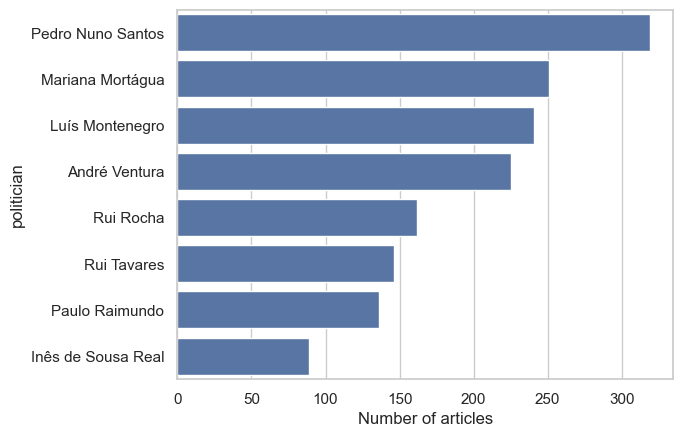

In [38]:
sns.set_theme(style="whitegrid")
sns.barplot(expanded_sentiments.loc[mask_politican, "politician"].value_counts(), orient = 'h')
plt.xlabel("Number of articles")

In [ ]:
scores_df = expanded_sentiments[~expanded_sentiments.score.isnull() & mask_politican]

<Axes: xlabel='quote_score', ylabel='Density'>

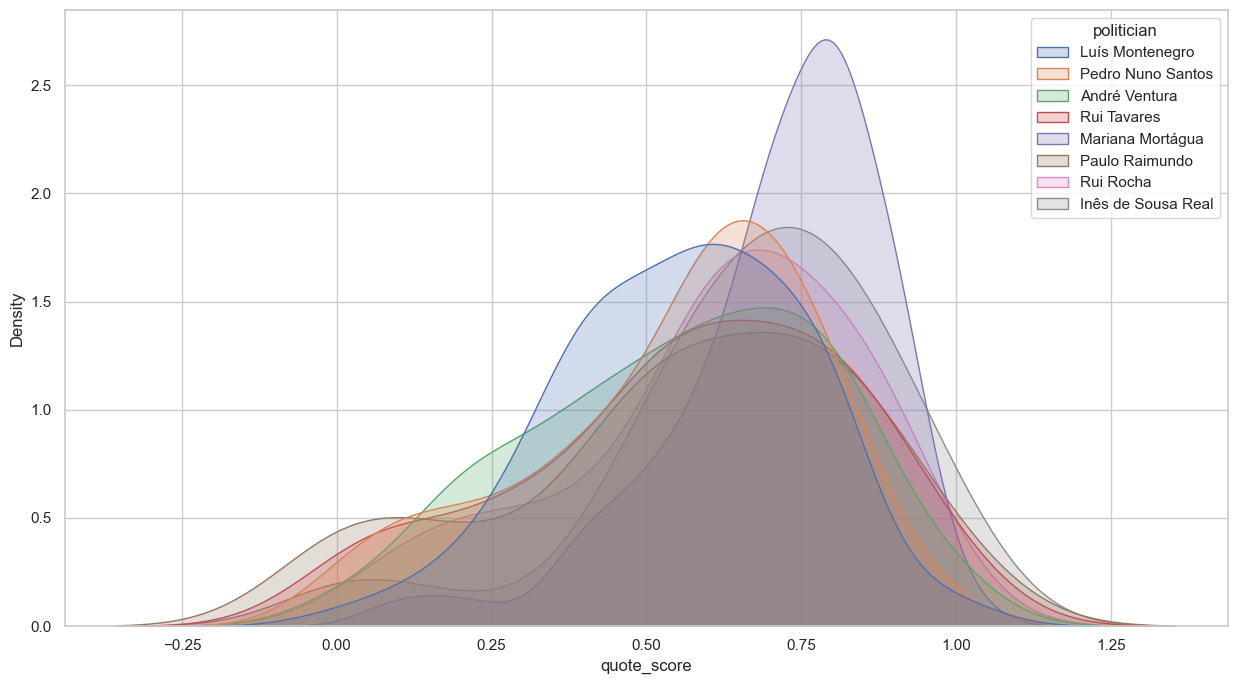

In [115]:
fig = plt.figure(figsize=(15, 8))
sns.kdeplot(data=scores_df, x="quote_score", hue="politician", fill=True, common_norm=False)

In [130]:
scores_df.score.mean()

0.5593245967741935

In [164]:
def mean_plot(*args, **kwargs):
    data = kwargs.pop("data")
    x_col = kwargs.pop("x")
    ymin = kwargs.pop("ymin")
    ymax = kwargs.pop("ymax")
    return plt.vlines(data[x_col].mean(), ymin=ymin, ymax=ymax, **kwargs)
    

In [173]:
politician_avg_scores = (
    scores_df
    .groupby("politician")["score"]
    .mean()
    .reset_index()
)
politician_avg_scores.sort_values("score", ascending=False, inplace=True)
politician_avg_scores

,politician,score
3,Mariana Mortágua,0.704975
1,Inês de Sousa Real,0.661111
6,Rui Rocha,0.580220
4,Paulo Raimundo,0.553750
7,Rui Tavares,0.536458
5,Pedro Nuno Santos,0.507513
2,Luís Montenegro,0.480870
0,André Ventura,0.466667


Text(0.5, 0.92, 'Politicians positivity score')

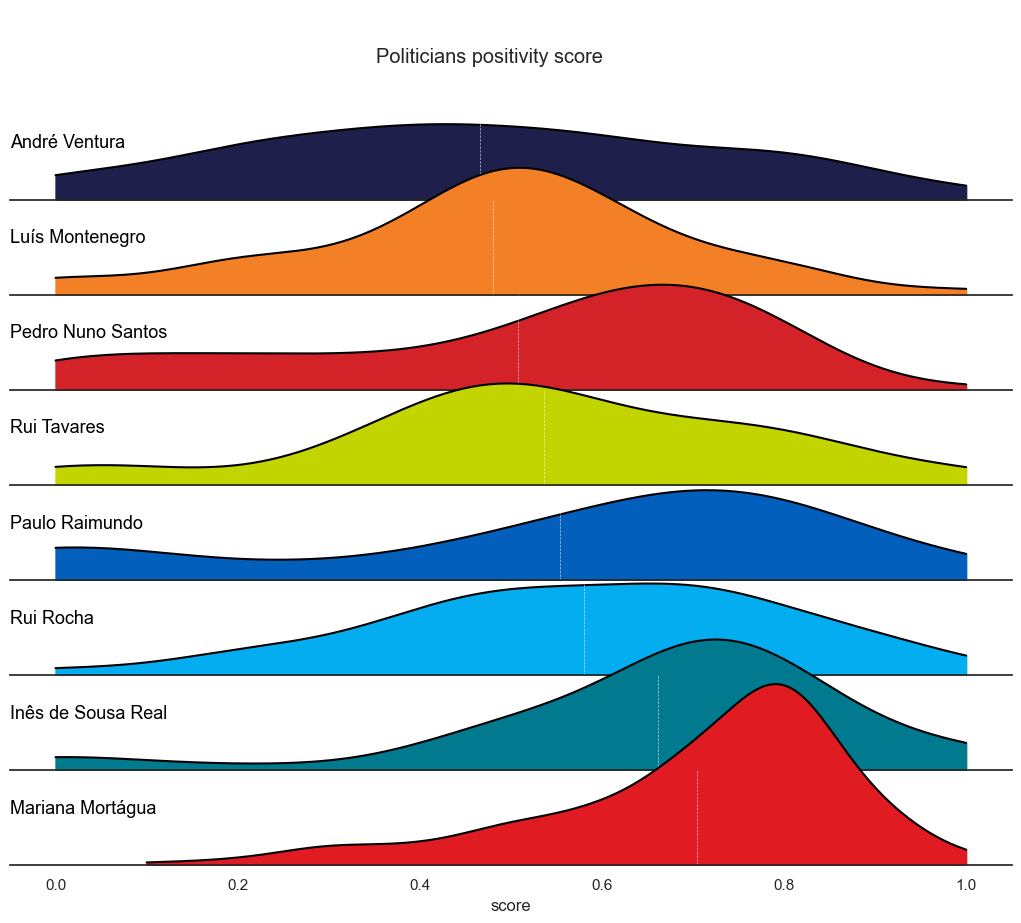

In [444]:
#sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
row_order = politician_avg_scores.politician.tolist()[::-1]

colors = [constants.POLITICIAN_COLORS[name] for name in row_order]
palette = sns.set_palette(sns.color_palette(colors))

g = sns.FacetGrid(scores_df, palette=palette, row="politician", hue="politician",
    hue_order=row_order, row_order=row_order, aspect=9, height=1.2
)
g.map_dataframe(sns.kdeplot, x="score", fill=True, alpha=1, cut=0)
g.map_dataframe(sns.kdeplot, x="score", color='black', cut=0)
g.map_dataframe(mean_plot, x="score", ymin=0, ymax=1.7, alpha=0.7, linewidth=0.5, color="white", linestyle="--")
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .3, label, color='black', fontsize=13,
        ha="left", va="center", transform=ax.transAxes
    )

g.map(label, "score")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="score", ylabel="")
g.despine( left=True)
plt.suptitle('Politicians positivity score', y=0.92)

In [459]:
scores_df[scores_df.politician == "Paulo Raimundo"]

,quote,quote_score,name,score,article_id,politician
76,"Quase na reta final dos debates televisivos, P...",0.8,Paulo Raimundo,0.8,33,Paulo Raimundo
198,Paulo Raimundo considera que o PS de Pedro Nun...,0.4,Paulo Raimundo,0.0,77,Paulo Raimundo
199,O líder comunista nunca disse nunca a um enten...,0.3,Paulo Raimundo,0.0,77,Paulo Raimundo
200,"Depois das exigências na saúde e na educação, ...",0.2,Paulo Raimundo,0.0,77,Paulo Raimundo
201,Mas não vê grandes mudanças na nova liderança ...,0.1,Paulo Raimundo,0.0,77,Paulo Raimundo
...,...,...,...,...,...,...
1607,Um governo tão ágil a abrir processos discipli...,0.8,Paulo Raimundo,0.7,652,Paulo Raimundo
1608,"São justas reivindicações, de reconhecimento e...",0.6,Paulo Raimundo,0.7,652,Paulo Raimundo
1609,Um governo de gestão tem todas as condições de...,0.7,Paulo Raimundo,0.7,652,Paulo Raimundo
1610,Há 'milhares e milhares de força de segurança ...,0.5,Paulo Raimundo,0.7,652,Paulo Raimundo


In [466]:
politician_scores[politician_scores.article_id == 652]

,article_id,politician,score,n_quotes,title,description,pubdate,publisher,url,summary,keywords,text,creation_datetime,query
468,652,Paulo Raimundo,0.7,5,"Paulo Raimundo diz que Governo deveria ser ""tã...","Paulo Raimundo diz que Governo deveria ser ""tã...",2024-02-04,SIC Notícias,https://news.google.com/rss/articles/CBMipAFod...,O secretário-geral do PCP criticou este doming...,"[raimundo, sessão, responder, deveria, cdu, pc...",O secretário-geral do PCP criticou este doming...,2024-03-03T12:49:37.897427,Paulo Raimundo
469,652,Pedro Nuno Santos,0.6,3,"Paulo Raimundo diz que Governo deveria ser ""tã...","Paulo Raimundo diz que Governo deveria ser ""tã...",2024-02-04,SIC Notícias,https://news.google.com/rss/articles/CBMipAFod...,O secretário-geral do PCP criticou este doming...,"[raimundo, sessão, responder, deveria, cdu, pc...",O secretário-geral do PCP criticou este doming...,2024-03-03T12:49:37.897427,Paulo Raimundo


In [471]:
print(politician_scores[politician_scores.article_id == 404].text.iloc[0])

Paulo Raimundo rejeita que PS seja o principal inimigo do PCP

Secretário-geral do PCP considerou que o primeiro-ministro demissionário "decidiu ontem entrar em campanha eleitoral e entrou a pés juntos".


In [472]:
expanded_sentiments[expanded_sentiments.article_id == 404]

,quote,quote_score,name,score,article_id,politician
1024,Paulo Raimundo rejeita que PS seja o principal...,0.0,Paulo Raimundo,0.0,404,Paulo Raimundo
1025,NaN,NaN,PS,NaN,404,PS
1026,NaN,NaN,PCP,NaN,404,PCP


In [465]:
politician_scores[politician_scores.politician == "Paulo Raimundo"
                  ].sort_values(["pubdate", "article_id"], ascending=False).tail()

,article_id,politician,score,n_quotes,title,description,pubdate,publisher,url,summary,keywords,text,creation_datetime,query
268,403,Paulo Raimundo,0.5,2,"Paulo Raimundo: ""Quem faz promessas de um dia ...","Paulo Raimundo: ""Quem faz promessas de um dia ...",2024-01-08,SIC Notícias,https://news.google.com/rss/articles/CBMidmh0d...,Paulo Raimundo diz que quem faz promessas de u...,"[ps, raimundo, saúde, pcp, possibilidade, coli...",Paulo Raimundo diz que quem faz promessas de u...,2024-03-02T18:59:30.803379,Paulo Raimundo
57,77,Paulo Raimundo,0.0,5,Paulo Raimundo considera que o PS de Pedro Nun...,Paulo Raimundo considera que o PS de Pedro Nun...,2023-12-27,SIC Notícias,https://news.google.com/rss/articles/CBMiggFod...,O Secretário-geral do PCP considera que o PS d...,"[ps, raimundo, nuno, costa, partido, pedro, pc...",O Secretário-geral do PCP considera que o PS d...,2024-03-02T18:49:17.369839,Pedro Nuno Santos
307,450,Paulo Raimundo,0.8,2,Paulo Raimundo considera que Costa desperdiçou...,Paulo Raimundo considera que Costa desperdiçou...,2023-12-26,RTP Notícias,https://news.google.com/rss/articles/CBMidGh0d...,O secretário geral do PCP considera que Antóni...,"[raimundo, costa, visita, desperdiçou, resolve...",O secretário geral do PCP considera que Antóni...,2024-03-02T18:59:30.803379,Paulo Raimundo
267,402,Paulo Raimundo,0.8,2,"Costa ""desperdiçou dois anos das nossas vidas""...","Costa ""desperdiçou dois anos das nossas vidas""...",2023-12-26,Expresso,https://news.google.com/rss/articles/CBMieWh0d...,O secretário-geral do PCP considera insuficien...,"[presidente, raimundo, costa, problemas, despe...",O secretário-geral do PCP considera insuficien...,2024-03-02T18:59:30.803379,Paulo Raimundo
269,404,Paulo Raimundo,0.0,1,Paulo Raimundo rejeita que PS seja o principal...,Paulo Raimundo rejeita que PS seja o principal...,2023-12-12,Diário de Notícias,https://news.google.com/rss/articles/CBMiaGh0d...,Paulo Raimundo rejeita que PS seja o principal...,"[ps, raimundo, pés, pcp, pcpsecretáriogeral, i...",Paulo Raimundo rejeita que PS seja o principal...,2024-03-02T18:59:30.803379,Paulo Raimundo


In [413]:
politician_scores = (
    scores_df
    .groupby(["article_id", "politician"])
    .agg({"score": "mean", "quote": "count"})
    .rename(columns={"quote": "n_quotes"})
    .reset_index()
)

politician_scores = pd.merge(politician_scores, articles_df, on="article_id")
daily_scores = (
    politician_scores
    .groupby(["pubdate", "politician"])#["score"]
    .agg({"score": "mean", "n_quotes": "sum", "article_id": "count"})
    .rename(columns={"article_id": "n_articles"})
    .reset_index()
)
daily_scores


,pubdate,politician,score,n_quotes,n_articles
0,2023-12-09,Mariana Mortágua,0.80,3,1
1,2023-12-11,Mariana Mortágua,0.80,6,1
2,2023-12-12,Paulo Raimundo,0.00,1,1
3,2023-12-14,Mariana Mortágua,0.90,2,1
4,2023-12-16,Pedro Nuno Santos,0.10,1,1
...,...,...,...,...,...
221,2024-03-02,Luís Montenegro,0.30,2,2
222,2024-03-02,Mariana Mortágua,0.50,3,2
223,2024-03-02,Paulo Raimundo,0.00,3,1
224,2024-03-02,Pedro Nuno Santos,0.05,4,2


In [417]:
daily_scores["n_articles"].quantile(np.arange(0, 1.1, 0.1))

0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4    1.0
0.5    1.0
0.6    2.0
0.7    2.0
0.8    3.0
0.9    4.5
1.0    9.0
Name: n_articles, dtype: float64

In [437]:
daily_scores["n_quotes"].quantile(np.arange(0, 1.1, 0.1))

0.0     1.0
0.1     1.0
0.2     1.0
0.3     2.0
0.4     3.0
0.5     3.0
0.6     4.0
0.7     5.0
0.8     7.0
0.9    10.0
1.0    21.0
Name: n_quotes, dtype: float64

In [402]:
daily_scores_feb = daily_scores[daily_scores["pubdate"] >= date(2024, 2, 1)].copy()
daily_scores_feb.sort_values(["politician", "pubdate"], inplace=True)
daily_scores_feb

,pubdate,politician,score
73,2024-02-03,André Ventura,0.800000
81,2024-02-05,André Ventura,0.380000
85,2024-02-06,André Ventura,0.480000
91,2024-02-07,André Ventura,0.333333
97,2024-02-08,André Ventura,0.700000
...,...,...,...
196,2024-02-26,Rui Tavares,0.800000
208,2024-02-28,Rui Tavares,0.600000
214,2024-02-29,Rui Tavares,0.480000
218,2024-03-01,Rui Tavares,0.566667


In [404]:
def interpolate_date(df, window_size=3):
    df_ = df[["pubdate", "score"]].copy()
    df_.set_index("pubdate", inplace=True)
    dates = pd.date_range(start=df["pubdate"].min(), end=df["pubdate"].max(), freq='D')
    df_ = df_.reindex(dates)
    df_.index.rename(name="pubdate", inplace=True)
    df_["score_filled"] = (df_["score"].bfill() + df_["score"].ffill()) / 2
    df_["score_smooth"] = df_["score_filled"].rolling(window_size, min_periods=1).mean()
    return df_

daily_smooth_scores = daily_scores_feb.groupby("politician").apply(interpolate_date).reset_index()
daily_smooth_scores

,politician,pubdate,score,score_filled,score_smooth
0,André Ventura,2024-02-03,0.800000,0.800000,0.800000
1,André Ventura,2024-02-04,NaN,0.590000,0.695000
2,André Ventura,2024-02-05,0.380000,0.380000,0.590000
3,André Ventura,2024-02-06,0.480000,0.480000,0.483333
4,André Ventura,2024-02-07,0.333333,0.333333,0.397778
...,...,...,...,...,...
225,Rui Tavares,2024-02-27,NaN,0.700000,0.783333
226,Rui Tavares,2024-02-28,0.600000,0.600000,0.700000
227,Rui Tavares,2024-02-29,0.480000,0.480000,0.593333
228,Rui Tavares,2024-03-01,0.566667,0.566667,0.548889


In [270]:
def smooth_line_coords(df: pd.DataFrame) -> pd.DataFrame:
    """
    Use a spline interpolation to smooth the line of the scores.
    
    Args:
        df: A DataFrame with the columns "days", "pubdate" and "score".
    
    Returns:
        A DataFrame with the columns:
            1. pubdate_smooth: which places virtual pubdates in the interval of the real pubdates
            2. score_smooth: the spline interpolation of the scores at the virtual pubdates.
    """
    spline = interpolate.UnivariateSpline(df["days"], df["score"])
    days_smooth = np.linspace(0, df["days"].max(), 200)
    datetime_smooth = pd.to_datetime(df["pubdate"].min()) + pd.to_timedelta(days_smooth, "day")
    score_smooth = spline(days_smooth)
    return pd.DataFrame({"pubdate_smooth": datetime_smooth, "score_smooth": score_smooth})

daily_scores_feb.groupby("politician").apply(smooth_line_coords).reset_index().sort_values("pubdate_smooth")

In [398]:
daily_smooth_scores[daily_smooth_scores.politician=="Paulo Raimundo"]

,politician,pubdate,score,score_filled,score_smooth
116,Paulo Raimundo,2024-02-02,0.800000,0.800000,0.800000
117,Paulo Raimundo,2024-02-03,NaN,0.750000,0.775000
118,Paulo Raimundo,2024-02-04,0.700000,0.700000,0.750000
119,Paulo Raimundo,2024-02-05,NaN,0.600000,0.683333
120,Paulo Raimundo,2024-02-06,NaN,0.600000,0.633333
121,Paulo Raimundo,2024-02-07,0.500000,0.500000,0.566667
122,Paulo Raimundo,2024-02-08,NaN,0.500000,0.533333
123,Paulo Raimundo,2024-02-09,0.500000,0.500000,0.500000
124,Paulo Raimundo,2024-02-10,0.450000,0.450000,0.483333
125,Paulo Raimundo,2024-02-11,0.800000,0.800000,0.583333


<Axes: xlabel='pubdate', ylabel='score_smooth'>

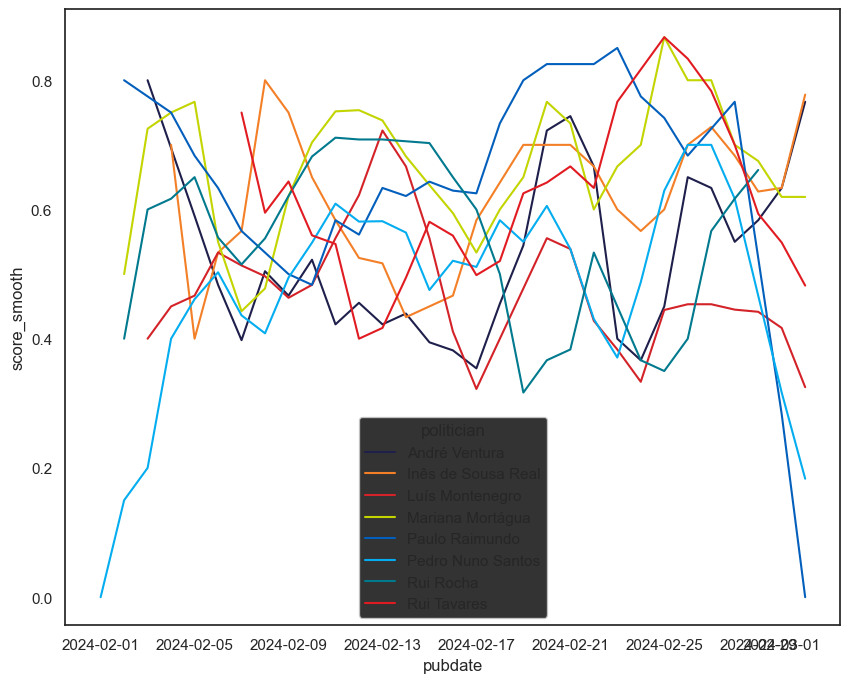

In [395]:
fig = plt.figure(figsize=(10, 8))
sns.lineplot(
    data=daily_smooth_scores,
    x="pubdate", y="score_smooth", hue="politician"
)

In [456]:
expanded_sentiments[mask_has_score & (expanded_sentiments["politician"] == "Paulo Raimundo")].sort_values("article_id")

,quote,quote_score,name,score,article_id,politician
76,"Quase na reta final dos debates televisivos, P...",0.8,Paulo Raimundo,0.8,33,Paulo Raimundo
198,Paulo Raimundo considera que o PS de Pedro Nun...,0.4,Paulo Raimundo,0.0,77,Paulo Raimundo
199,O líder comunista nunca disse nunca a um enten...,0.3,Paulo Raimundo,0.0,77,Paulo Raimundo
200,"Depois das exigências na saúde e na educação, ...",0.2,Paulo Raimundo,0.0,77,Paulo Raimundo
201,Mas não vê grandes mudanças na nova liderança ...,0.1,Paulo Raimundo,0.0,77,Paulo Raimundo
...,...,...,...,...,...,...
1609,Um governo de gestão tem todas as condições de...,0.7,Paulo Raimundo,0.7,652,Paulo Raimundo
1610,Há 'milhares e milhares de força de segurança ...,0.5,Paulo Raimundo,0.7,652,Paulo Raimundo
1607,Um governo tão ágil a abrir processos discipli...,0.8,Paulo Raimundo,0.7,652,Paulo Raimundo
1608,"São justas reivindicações, de reconhecimento e...",0.6,Paulo Raimundo,0.7,652,Paulo Raimundo


In [448]:
expanded_sentiments["politician"] == "Paulo Raimundo"

0       False
1       False
2       False
3       False
4       False
        ...  
1672    False
1673    False
1674    False
1675     True
1676    False
Name: politician, Length: 1677, dtype: bool

In [14]:
# articles the have no sentiments
mask_has_score = ~expanded_sentiments["score"].isnull()
article_ids_with_score = expanded_sentiments.loc[mask_has_score, "article_id"].unique()
article_ids_no_score_set = set(expanded_sentiments["article_id"].unique()) - set(article_ids_with_score)
article_ids_no_score = np.sort(list(article_ids_no_score_set))
article_ids_no_score

array([  3,   4,   5,   6,   7,   8,  10,  11,  14,  16,  17,  19,  21,
        25,  26,  27,  29,  30,  34,  35,  37,  40,  43,  45,  53,  54,
        55,  56,  59,  61,  63,  65,  69,  71,  73,  74,  76,  78,  79,
        80,  82,  83,  84,  86,  88,  90,  91,  92,  94,  97,  99, 100,
       103, 104, 107, 110, 111, 117, 118, 120, 122, 123, 124, 125, 126,
       128, 129, 130, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143,
       146, 150, 151, 153, 154, 155, 156, 157, 160, 161, 163, 164, 166,
       169, 170, 172, 173, 175, 177, 178, 179, 180, 184, 185, 186, 188,
       191, 193, 194, 200, 203, 204, 205, 209, 215, 218, 224, 225, 229,
       230, 233, 237, 243, 245, 247, 249, 250, 251, 253, 254, 255, 260,
       261, 263, 264, 267, 269, 271, 272, 274, 277, 279, 287, 288, 292,
       293, 295, 296, 299, 301, 304, 310, 311, 315, 317, 318, 319, 320,
       327, 331, 332, 333, 350, 351, 353, 354, 364, 366, 367, 370, 372,
       373, 376, 381, 382, 383, 385, 387, 389, 390, 391, 392, 39

In [15]:
len(article_ids_no_score)

289

In [16]:
len(article_ids_with_score)

317